# Tumor Diagnosis

In this project, we aim to apply data analysis, dimensionality reduction, and clustering techniques to better understand the tumor characteristics and their classification.

### 01. Import libraries

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import time
import json
import math

# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, \
    classification_report, confusion_matrix

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

### 02. Import data

__Class distribution:__
- __diagnosis__: Target column containing the class $labels$
  - $M$ - $Malignant$ $\rightarrow$ Tending to invade normal tissue, indicating a more harmful nature.
  - $B$ - $Benign$ $\rightarrow$ Not harmful, indicating a non-invasive and less concerning form.

__Columns in the dataset:__

0. __id__ Contains unique identifiers for each record. As a unique identifier, it cannot be used for classification purposes.
1. __radius__ Mean of distances from the center to points on the perimeter of the nucleus.
2. __texture__ Standard deviation of the gray-scale values.
3. __perimeter__ Total distance around the boundary of the nucleus.
4. __area__ Total area of the nucleus.
5. __smoothness__ Local variation in radius lengths, indicating the smoothness of the boundary.
6. __compactness__ Indicating how compact the nucleus is. (perimeter^2 / area - 1.0) 
7. __concavity__ Severity of concave portions of the contour, measuring how inward the boundary is.
8. __concave points__ Number of concave portions on the contour of the nucleus.
9. __symmetry__ Measures the symmetry of the nucleus.
10. __fractal dimension__ A measure of the "coastline approximation", calculated as the ratio of the perimeter to area.

In [3]:
# Find principal path of the project
from pathlib import Path
project_root = str(Path.cwd().parents[0])

# Load the column names from the JSON file
with open(project_root + '.\static\column_names.json', 'r') as json_file:
    saved_column_names = json.load(json_file)

# Read the .data file into a Pandas DataFrame
df = pd.read_csv(project_root + '.\static\wdbc.data', header=None, names=saved_column_names)

# Display the first few rows of the DataFrame
df.head()

,id,diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Beautifully formatted output for dataset details
print(f"Data Points (Rows)   : {df.shape[0]:,}")
print(f"Features (Columns)   : {df.shape[1]}")
print(f"Feature Names        : {', '.join(df.columns)}")

Data Points (Rows)   : 569
Features (Columns)   : 32
Feature Names        : id, diagnosis, radius1, texture1, perimeter1, area1, smoothness1, compactness1, concavity1, concave_points1, symmetry1, fractal_dimension1, radius2, texture2, perimeter2, area2, smoothness2, compactness2, concavity2, concave_points2, symmetry2, fractal_dimension2, radius3, texture3, perimeter3, area3, smoothness3, compactness3, concavity3, concave_points3, symmetry3, fractal_dimension3


### 03. Data preprocesing

In this step, the unique identifier column will be removed from the dataset, as it does not contribute to the classification task. Additionally, we will perform label encoding on the $diagnosis$ column to transform the categorical labels into numerical values, making them suitable for machine learning models.

The LabelEncoder from sklearn.preprocessing will be used to convert the labels in the diagnosis column ('B' for Benign and 'M' for Malignant) to binary values (0 and 1).

In [5]:
# The 'id' column is an arbitrary identifier with no meaningful contribution 
# to pattern analysis, correlations, or clustering, and may introduce noise into the model.
df_cleaned = df.drop(columns=['id'])

In [6]:
# Creating an instance of LabelEncoder to perform label encoding
label_encoder = LabelEncoder()

# Convert 'diagnosis' column from 'b' and 'm' to 0 and 1
df_cleaned['diagnosis'] = label_encoder.fit_transform(df_cleaned['diagnosis'])

In [7]:
# See preprocessing result
df_cleaned.head()

,diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 04. Correlation Analysis

The purpose of this analysis is to examine the correlation between the features in the dataset. Identifying highly correlated features is important because multicollinearity can negatively impact model performance. However, in this case, we will not remove any features, as we want to evaluate their influence on the performance of PCA (Principal Component Analysis) and clustering in later stages of the analysis.

In [8]:
# Create correlation matrix
corr_matrix = df_cleaned.corr()

In [ ]:
# Create Pairplot from Seaborn to see relationship between individual features and diagnosis
# 'Benign (0)', 'Malignant (1)'
sns.pairplot(df_cleaned, palette='coolwarm', hue='diagnosis')

# Adjust legend position to the upper left corner
plt.legend(title='Diagnosis', loc='upper left', labels=['Benign (0)', 'Malignant (1)'], fontsize=12)

# Show the plot
plt.show()

In [ ]:
# Distribution of Features
plt.figure(figsize=(19, 17))

# Automatically get numerical columns
numerical_features = df_cleaned.select_dtypes(include=['number']).columns

# Number of rows and columns for subplots
rows = math.ceil(len(df_cleaned.columns) / 3)
cols = 3

# Adjust the figure size
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))

# Flatten the axis array for easy access
ax = ax.flatten()

# Iterate over the numerical features
for i in range(len(numerical_features)):
    sns.histplot(df_cleaned[numerical_features[i]], color='crimson', kde=True, ax=ax[i])
    ax[i].set_title(f'Distribution: {numerical_features[i]}')

# Remove unused subplots if there are fewer features
for j in range(i + 1, rows * cols):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [ ]:
# Plot the correlation matrix
plt.figure(figsize=(19, 17))
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, annot=True, annot_kws={"size": 8}, fmt=".2f")
plt.show()

In [9]:
# Mask the diagonal (set to NaN) to avoid self-correlation
np.fill_diagonal(corr_matrix.values, np.nan)

# Stack the correlation matrix and sort the values
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)

# Show the pairs with the highest correlation, excluding the diagonal
corr_pairs.head(10)

radius1     perimeter1    0.997855
perimeter1  radius1       0.997855
radius3     perimeter3    0.993708
perimeter3  radius3       0.993708
radius1     area1         0.987357
area1       radius1       0.987357
perimeter1  area1         0.986507
area1       perimeter1    0.986507
radius3     area3         0.984015
area3       radius3       0.984015
dtype: float64

### 05. Logistic Regression

Logistic Regression is a supervised classification algorithm used to predict the probability of an outcome that can have two categories (binary classification). It models the relationship between the features and the probability of a specific class using a sigmoid (logistic) function.

- __Input Features:__ Logistic regression works well when features are linear or can be transformed into a linear relationship with the target. Features need to be standardized if they vary significantly in scale to ensure fair contribution to the model.

- __Logistic Function (Sigmoid):__ The logistic regression model uses the sigmoid function to map predicted values into probabilities between 0 and 1.

$$sigma(z) = \frac{1}{1 + e^{-z}}$$

$$z = w_1x_1 + w_2x_2 + \dots + w_nx_n + b$$

- __Thresholding:__ Once the model outputs probabilities, a threshold (commonly 0.5) is applied to classify observations into one of the two categories.

In [10]:
# Features and target
X = df_cleaned.iloc[:, 1:]  # Features (skip diagnosis)
y = df_cleaned['diagnosis']  # Target

In [11]:
# Split the dataset
# Stratify ensures that the proportion of classes in the training and test sets is similar to the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Standardizes the features so that they have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

### 09. Model evaluation and interpretation

In this step, we will evaluate the performance of the logistic regression model by examining its ability to classify diagnoses accurately. 

In [14]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Accuracy: 0.97
Precision: 0.98
Recall: 0.95
F1 Score: 0.96
ROC-AUC: 1.00


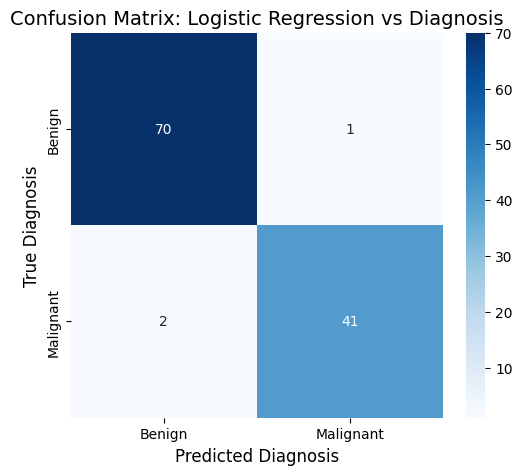

In [15]:
# Plotting the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix: Logistic Regression vs Diagnosis', fontsize=14)
plt.xlabel('Predicted Diagnosis', fontsize=12)
plt.ylabel('True Diagnosis', fontsize=12)
plt.show()

In [16]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



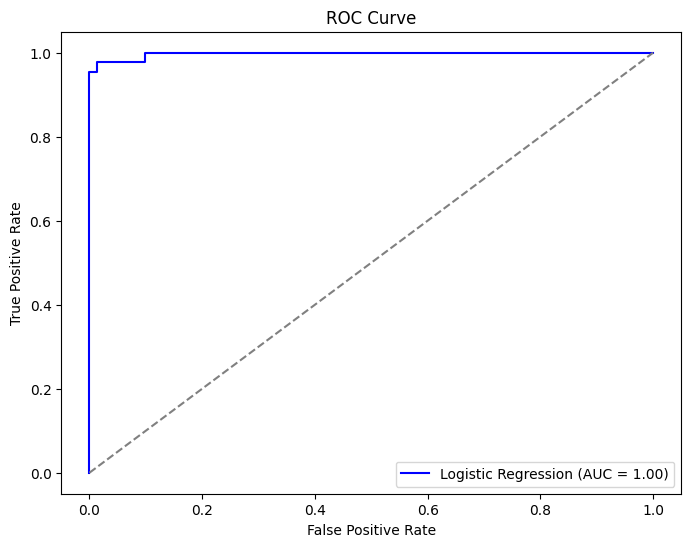

In [17]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

__Metrics__
- Accuracy (0.97): The model correctly classifies 97% of the instances. This is a strong indication of its overall reliability in distinguishing between malignant and benign cases.

- Precision (0.98): Out of all the cases the model predicted as malignant, 98% were indeed malignant. This metric highlights the model's ability to avoid false positives (incorrectly predicting benign cases as malignant).

- Recall (0.95): The model successfully identified 95% of the actual malignant cases, which shows its capability to minimize false negatives (failing to detect malignant cases).

- F1 Score (0.96): The F1 score balances precision and recall, providing a harmonic mean. A score of 0.96 confirms the model's robustness in handling both false positives and false negatives.

- ROC-AUC (1.00): The model achieved perfect separation between the malignant and benign classes, demonstrating its exceptional ability to differentiate between the two.


__Conclusion__

In summary, __false positives (FP)__ and __false negatives (FN)__ are critical in cancer diagnosis because they have direct implications on patient health and treatment. Managing these cases requires thorough review, additional testing, continuous monitoring, and refining the models to minimize these errors. Collaborating with medical specialists and integrating advanced diagnostic technologies are essential to improving accuracy and reducing the risks associated with diagnostic errors.

The model’s performance underscores the effectiveness of logistic regression in this context, demonstrating its potential as a reliable tool for aiding in cancer diagnosis. However, validation with domain experts and real-world data is essential to ensure clinical applicability.

### End